# style transfer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import image
import keras.backend as K

In [0]:
target_image_path = "/content/drive/My Drive/style_transfer/Style_Transfer/test/pulkit.jpg"
style_reference_image_path = "/content/drive/My Drive/style_transfer/Style_Transfer/test/image2.jpg"

img_height = 400
img_width = 500


In [0]:
def preprocess_image(path):
    img = image.load_img(path,target_size=(img_height,img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    return img

def deprocess_image(x):
    x[ :, :, 0] += 103.939
    x[ :, :, 1] += 116.779
    x[ :, :, 2] += 123.68
    
    x = x[:, :, ::-1]
    x = np.clip(x,0,255).astype('uint8')
    return x

In [0]:
def content_loss(base , combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gram = K.dot(features , K.transpose(features))
    return gram

def style_loss(style , combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    
    return K.sum(K.square( S - C )) / (4 * (channels**2) * (size**2) )

def total_variation_loss(x):
    a = K.square(x[:, :img_height-1 , :img_width -1 ,:] - x[:, 1:, :img_width-1 ,:])
    b = K.square(x[:, :img_height-1 , :img_width -1 ,:] - x[:, :img_height-1,1: ,:])
    
    return K.sum(K.pow(a+b,1.25))

    

In [0]:
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1,img_height,img_width,3))

input_tensor = K.concatenate([target_image,style_reference_image,combination_image],axis=0)

model =VGG16(weights = 'imagenet' ,input_tensor = input_tensor ,include_top = False)


In [33]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:

# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

start of iteration 0
current loss value  1144316900.0


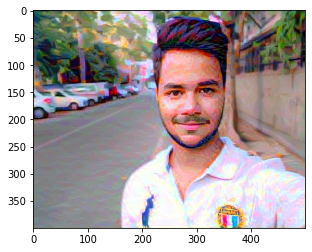

start of iteration 1
current loss value  503157000.0


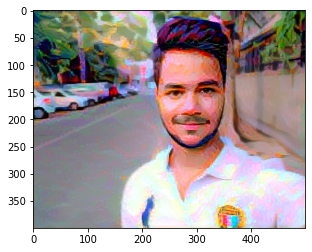

start of iteration 2
current loss value  312718980.0


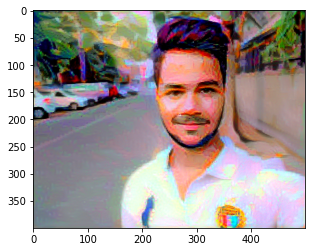

start of iteration 3
current loss value  226982340.0


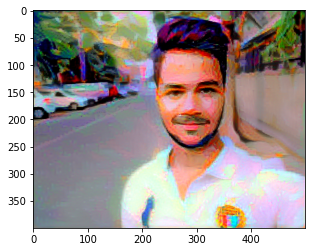

start of iteration 4
current loss value  171900030.0


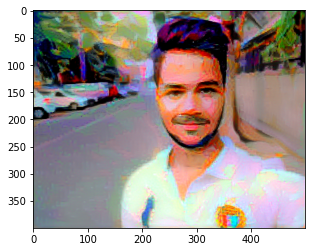

start of iteration 5
current loss value  140338450.0


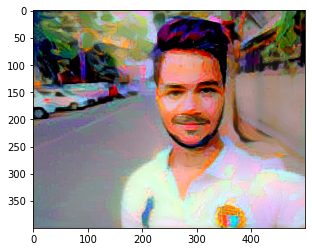

start of iteration 6
current loss value  116913110.0


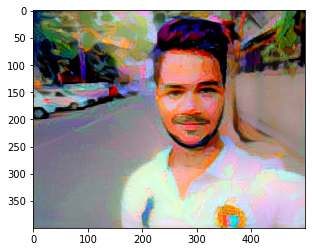

start of iteration 7
current loss value  101288180.0


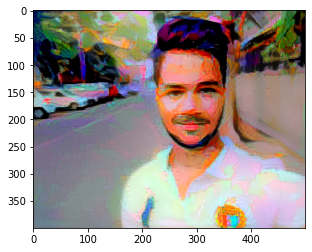

start of iteration 8
current loss value  87822424.0


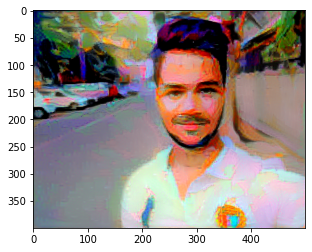

start of iteration 9
current loss value  75590744.0


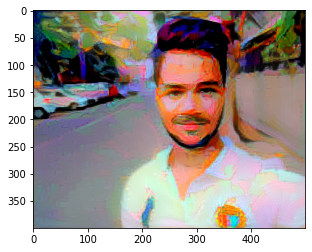

In [35]:
from scipy.optimize import fmin_l_bfgs_b

import time

iterations = 10

x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
    print("start of iteration", i)
    start_time = time.time()
    x ,min_val,info = fmin_l_bfgs_b(evaluator.loss,x,fprime=evaluator.grads,maxfun = 20)
    print("current loss value ",min_val)
    
    img = x.copy().reshape((img_height,img_width,3))
    img = deprocess_image(img)
    plt.imshow(img)
    plt.show()
